In [1]:
import os 
import cv2
import glob
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.layers import Dense
from keras.models import Sequential
from keras.preprocessing import image
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from keras.layers import Convolution2D,Dense,MaxPool2D,Activation,Dropout,Flatten
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.utils import load_img, img_to_array
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
import PIL
import pathlib

2022-08-25 15:24:56.906863: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/amadon/.local/lib/python3.8/site-packages/cv2/../../lib64:
2022-08-25 15:24:56.906907: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
BATCH_SIZE = 32
IMG_SIZE = (100, 100)
INPUT_SHAPE = (100, 100, 3)

train_dir = pathlib.Path('data_dir/train/')
test_dir = pathlib.Path('data_dir/test/')
val_dir = pathlib.Path('data_dir/valid/')

category = []
for folder in os.listdir(train_dir):
    category.append(folder)
    
num_classes = len(category)

In [3]:
train_datagen=ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=40,
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    horizontal_flip=True,
    fill_mode='nearest'
    )
test_datagen=ImageDataGenerator(rescale=1./255)

# VGG19 Model

In [4]:
train_dataset = test_datagen.flow_from_directory(train_dir,
                                                batch_size=BATCH_SIZE,
                                                target_size=IMG_SIZE)

Found 9285 images belonging to 75 classes.


In [5]:
test_dataset = test_datagen.flow_from_directory(test_dir,
                                                batch_size=BATCH_SIZE,
                                                target_size=IMG_SIZE)

Found 375 images belonging to 75 classes.


In [6]:
val_dataset = test_datagen.flow_from_directory(val_dir,
                                                batch_size=BATCH_SIZE,
                                                target_size=IMG_SIZE)

Found 375 images belonging to 75 classes.


In [7]:
gg19base_model = VGG19(
    weights = "imagenet",
    include_top=False, 
    input_shape = INPUT_SHAPE
    ) 

2022-08-25 15:25:01.094852: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/amadon/.local/lib/python3.8/site-packages/cv2/../../lib64:
2022-08-25 15:25:01.094915: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-25 15:25:01.095210: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (amadon-virtual-machine): /proc/driver/nvidia/version does not exist
2022-08-25 15:25:01.095477: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
vgg19base_model.trainable = False

In [9]:
vgg19base_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 100, 100, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 100, 100, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 50, 50, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 50, 50, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 50, 50, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 25, 25, 128)       0     

In [10]:
model = vgg19base_model
x = model.output
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
predictions = tf.keras.layers.Dense(num_classes, activation="softmax")(x)   

vgg19_model = tf.keras.Model(
    inputs = model.input, 
    outputs = predictions)

vgg19_model.compile(loss='categorical_crossentropy', 
                       optimizer=tf.keras.optimizers.Adam(), 
                       metrics=['accuracy'])  

In [11]:
vgg19_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 100, 100, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 100, 100, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 50, 50, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 50, 50, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 50, 50, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 25, 25, 128)       0     

In [12]:
initial_epochs = 10

simplevgg19_history = vgg19_model.fit(
    train_dataset,
    epochs=initial_epochs,
    validation_data=val_dataset,
    verbose=1,
)

Epoch 1/10


2022-08-25 15:25:06.522003: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 81920000 exceeds 10% of free system memory.
2022-08-25 15:25:07.066409: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 81920000 exceeds 10% of free system memory.
2022-08-25 15:25:07.612392: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 20480000 exceeds 10% of free system memory.
2022-08-25 15:25:07.632552: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 40960000 exceeds 10% of free system memory.
2022-08-25 15:25:07.713917: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 40960000 exceeds 10% of free system memory.


291/291 [==============================] - 287s 981ms/step - loss: 2.3866 - accuracy: 0.4280 - val_loss: 1.2382 - val_accuracy: 0.6720
Epoch 2/10
291/291 [==============================] - 284s 975ms/step - loss: 1.0311 - accuracy: 0.7305 - val_loss: 0.9510 - val_accuracy: 0.7307
Epoch 3/10
291/291 [==============================] - 286s 984ms/step - loss: 0.6717 - accuracy: 0.8165 - val_loss: 0.8195 - val_accuracy: 0.7467
Epoch 4/10
291/291 [==============================] - 279s 959ms/step - loss: 0.4575 - accuracy: 0.8830 - val_loss: 0.7144 - val_accuracy: 0.7813
Epoch 5/10
291/291 [==============================] - 285s 981ms/step - loss: 0.3362 - accuracy: 0.9175 - val_loss: 0.7042 - val_accuracy: 0.7973
Epoch 6/10
291/291 [==============================] - 312s 1s/step - loss: 0.2314 - accuracy: 0.9471 - val_loss: 0.6224 - val_accuracy: 0.8160
Epoch 7/10
291/291 [==============================] - 283s 972ms/step - loss: 0.1444 - accuracy: 0.9729 - val_loss: 0.6610 - val_accuracy:

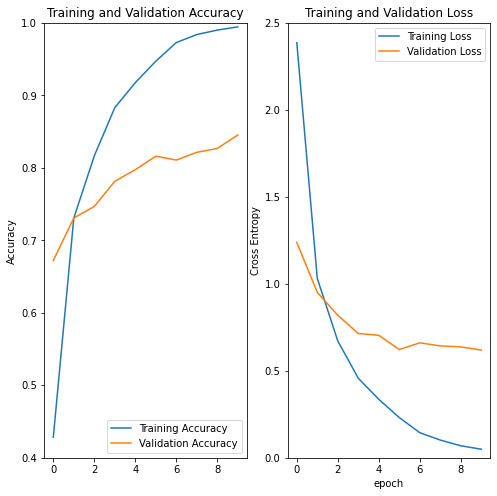

In [13]:
acc = simplevgg19_history.history['accuracy']
val_acc = simplevgg19_history.history['val_accuracy']

loss = simplevgg19_history.history['loss']
val_loss = simplevgg19_history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,2.5])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [14]:
print("[INFO] Calculating model accuracy")
scores = vgg19_model.evaluate(test_dataset)
print(f"Test Accuracy: {scores[1]*100}%")

[INFO] Calculating model accuracy
12/12 [==============================] - 11s 915ms/step - loss: 0.6538 - accuracy: 0.8427
Test Accuracy: 84.26666855812073%


1/1 [==============================] - 0s 248ms/step
This image most likely belongs to ADONIS with a 84.27 percent confidence.
ADONIS


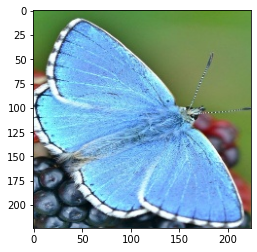

In [15]:
classes=list(train_dataset.class_indices.keys())
# Pre-Processing test data same as train data.
def prepare(img_path):
    img = tf.keras.utils.load_img(img_path, target_size=IMG_SIZE)
    x = tf.keras.utils.img_to_array(img)
    x = x/255
    return np.expand_dims(x, axis=0)
    
img_url=r'data_dir/6 images/4.jpg'
result_basevgg19= vgg19_model.predict([prepare(img_url)])
butterfly=tf.keras.utils.load_img(img_url)
plt.imshow(butterfly)

classresult=np.argmax(result_basevgg19,axis=1)

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(classes[classresult[0]], 100 * np.max(scores))
)
print(classes[classresult[0]])

In [16]:
vgg19_model.save('simplevgg19_model.h5')

In [17]:
train_dataset = test_datagen.flow_from_directory(train_dir,
                                                batch_size=BATCH_SIZE,
                                                target_size=IMG_SIZE)

Found 9285 images belonging to 75 classes.


In [18]:
inputs = tf.keras.Input(shape=INPUT_SHAPE)
x = vgg19base_model(inputs, training=False)
x = layers.Dropout(0.4)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
predictions = layers.Dense(num_classes, activation="softmax")(x)   

augvgg19_model = tf.keras.Model(
    inputs, 
    outputs = predictions)

base_learning_rate = 0.0005

augvgg19_model.compile(loss='categorical_crossentropy', 
                       optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate), 
                       metrics=['accuracy'])  

In [19]:
augvgg19_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 vgg19 (Functional)          (None, 3, 3, 512)         20024384  
                                                                 
 dropout (Dropout)           (None, 3, 3, 512)         0         
                                                                 
 flatten_1 (Flatten)         (None, 4608)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               1179904   
                                                                 
 dense_3 (Dense)             (None, 75)                19275     
                                                                 
Total params: 21,223,563
Trainable params: 1,199,179
Non-tr

In [20]:
augvgg19_history = augvgg19_model.fit(
    train_dataset,
    epochs=initial_epochs,
    validation_data=val_dataset,
    verbose=1,
)

Epoch 1/10
291/291 [==============================] - 287s 980ms/step - loss: 2.8716 - accuracy: 0.3216 - val_loss: 1.4735 - val_accuracy: 0.6533
Epoch 2/10
291/291 [==============================] - 284s 975ms/step - loss: 1.4101 - accuracy: 0.6334 - val_loss: 0.9960 - val_accuracy: 0.7413
Epoch 3/10
291/291 [==============================] - 282s 969ms/step - loss: 0.9882 - accuracy: 0.7331 - val_loss: 0.8442 - val_accuracy: 0.7680
Epoch 4/10
291/291 [==============================] - 285s 979ms/step - loss: 0.8013 - accuracy: 0.7780 - val_loss: 0.7507 - val_accuracy: 0.7813
Epoch 5/10
291/291 [==============================] - 282s 969ms/step - loss: 0.6687 - accuracy: 0.8172 - val_loss: 0.7373 - val_accuracy: 0.7947
Epoch 6/10
291/291 [==============================] - 273s 937ms/step - loss: 0.5458 - accuracy: 0.8475 - val_loss: 0.6456 - val_accuracy: 0.8293
Epoch 7/10
291/291 [==============================] - 271s 930ms/step - loss: 0.4683 - accuracy: 0.8705 - val_loss: 0.6181 -

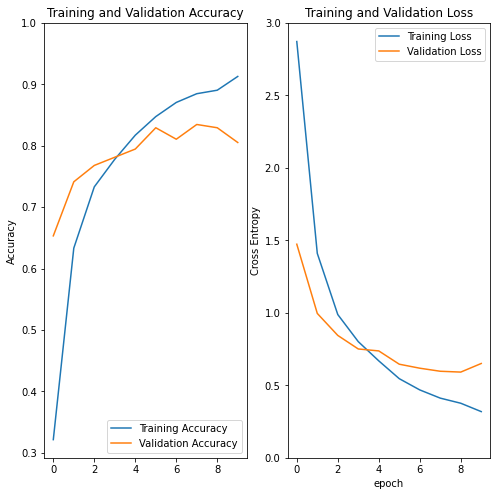

In [21]:
acc = augvgg19_history.history['accuracy']
val_acc = augvgg19_history.history['val_accuracy']

loss = augvgg19_history.history['loss']
val_loss = augvgg19_history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,3.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [22]:
print("[INFO] Calculating model accuracy")
scores = augvgg19_model.evaluate(test_dataset)
print(f"Test Accuracy: {scores[1]*100}%")

[INFO] Calculating model accuracy
12/12 [==============================] - 11s 902ms/step - loss: 0.7073 - accuracy: 0.8107
Test Accuracy: 81.06666803359985%


1/1 [==============================] - 0s 186ms/step
This image most likely belongs to ADONIS with a 81.07 percent confidence.
ADONIS


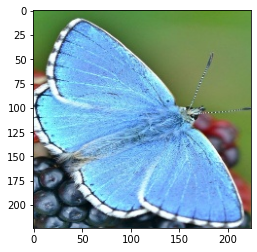

In [23]:
classes=list(train_dataset.class_indices.keys())
# Pre-Processing test data same as train data.
def prepare(img_path):
    img = tf.keras.utils.load_img(img_path, target_size=IMG_SIZE)
    x = tf.keras.utils.img_to_array(img)
    x = x/255
    return np.expand_dims(x, axis=0)
    
img_url=r'data_dir/6 images/4.jpg'
result_augvgg19= augvgg19_model.predict([prepare(img_url)])
butterfly=tf.keras.utils.load_img(img_url)
plt.imshow(butterfly)

classresult=np.argmax(result_augvgg19,axis=1)

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(classes[classresult[0]], 100 * np.max(scores))
)
print(classes[classresult[0]])

In [24]:
augvgg19_model.save('augvgg19_model.h5')

In [25]:
vgg19base_model.trainable = True

In [26]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(vgg19base_model.layers))

Number of layers in the base model:  22


In [27]:
# Fine-tune from this layer onwards
fine_tune_at = 20

# Freeze all the layers before the `fine_tune_at` layer
for layer in vgg19base_model.layers[:fine_tune_at]:
  layer.trainable = False

In [28]:
augvgg19_model.compile(loss='categorical_crossentropy', 
                       optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate/10), 
                       metrics=['accuracy'])  

augvgg19_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 vgg19 (Functional)          (None, 3, 3, 512)         20024384  
                                                                 
 dropout (Dropout)           (None, 3, 3, 512)         0         
                                                                 
 flatten_1 (Flatten)         (None, 4608)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               1179904   
                                                                 
 dense_3 (Dense)             (None, 75)                19275     
                                                                 
Total params: 21,223,563
Trainable params: 3,558,987
Non-tr

In [29]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

tunedvgg19_history = augvgg19_model.fit(
    train_dataset,
    epochs=total_epochs,
    initial_epoch=augvgg19_history.epoch[-1],
    validation_data=val_dataset,
    verbose=1
)

Epoch 10/20
291/291 [==============================] - 283s 966ms/step - loss: 0.2014 - accuracy: 0.9441 - val_loss: 0.4940 - val_accuracy: 0.8560
Epoch 11/20
291/291 [==============================] - 283s 973ms/step - loss: 0.1319 - accuracy: 0.9662 - val_loss: 0.5277 - val_accuracy: 0.8480
Epoch 12/20
291/291 [==============================] - 280s 962ms/step - loss: 0.1039 - accuracy: 0.9760 - val_loss: 0.5049 - val_accuracy: 0.8640
Epoch 13/20
291/291 [==============================] - 282s 969ms/step - loss: 0.0777 - accuracy: 0.9803 - val_loss: 0.4864 - val_accuracy: 0.8747
Epoch 14/20
291/291 [==============================] - 282s 968ms/step - loss: 0.0644 - accuracy: 0.9852 - val_loss: 0.4670 - val_accuracy: 0.8747
Epoch 15/20
291/291 [==============================] - 276s 950ms/step - loss: 0.0496 - accuracy: 0.9903 - val_loss: 0.4791 - val_accuracy: 0.8667
Epoch 16/20
291/291 [==============================] - 290s 997ms/step - loss: 0.0462 - accuracy: 0.9894 - val_loss: 0

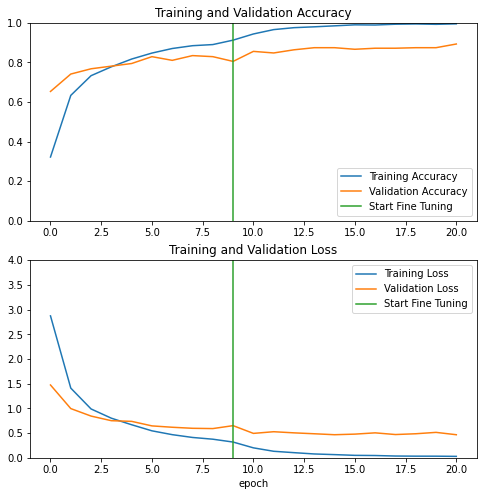

In [30]:
acc += tunedvgg19_history.history['accuracy']
val_acc += tunedvgg19_history.history['val_accuracy']

loss += tunedvgg19_history.history['loss']
val_loss += tunedvgg19_history.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 4.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [31]:
print("[INFO] Calculating model accuracy")
scores = augvgg19_model.evaluate(test_dataset)
print(f"Test Accuracy: {scores[1]*100}%")

[INFO] Calculating model accuracy
12/12 [==============================] - 11s 911ms/step - loss: 0.5982 - accuracy: 0.8747
Test Accuracy: 87.4666690826416%


1/1 [==============================] - 0s 169ms/step
This image most likely belongs to ADONIS with a 87.47 percent confidence.


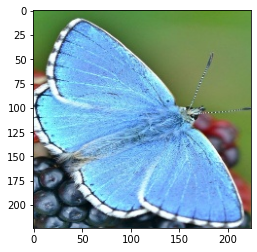

In [32]:
classes=list(train_dataset.class_indices.keys())
# Pre-Processing test data same as train data.
def prepare(img_path):
    img = tf.keras.utils.load_img(img_path, target_size=IMG_SIZE)
    x = tf.keras.utils.img_to_array(img)
    x = x/255
    return np.expand_dims(x, axis=0)
    
img_url=r'data_dir/6 images/4.jpg'
result_basevgg19= augvgg19_model.predict([prepare(img_url)])
butterfly=tf.keras.utils.load_img(img_url)
plt.imshow(butterfly)

classresult=np.argmax(result_basevgg19,axis=1)

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(classes[classresult[0]], 100 * np.max(scores))
)


In [33]:
augvgg19_model.save('tunedvgg19_model.h5')